In [1]:
basename = 'PlantVillage38-2Path5-LAB-m4-'
monitor='val_accuracy'
epochs=90
batch_size=32
input_shape=(128, 128, 3) # please resize it to (224,224,3) if you have enough RAM
Verbose=True

In [8]:
import sys
print("Python version:", sys.version)

import skimage
print('skimage:',  skimage.__version__)

import tensorflow as tf
print('Tensorflow:',tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import numpy as np
import seaborn as sns
import pickle


import matplotlib.pyplot as plt
%matplotlib inline

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
skimage: 0.21.0
Tensorflow: 2.13.0


In [9]:
#apt-get install git python3-opencv
import os

if not os.path.isdir('k'):
  !git clone https://github.com/hamidpeywasti/keras-neural-api k
else:
  !cd k && git pull

!cd k && pip install .

!rm -rf k

import cai
import cai.datasets
import cai.models
import cai.inception_v3
import cai.layers
import cai.util
from cai.layers import conv2d_bn

Cloning into 'k'...
remote: Enumerating objects: 1809, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 1809 (delta 135), reused 147 (delta 72), pack-reused 1588
Receiving objects: 100% (1809/1809), 15.69 MiB | 16.36 MiB/s, done.
Resolving deltas: 100% (1248/1248), done.
Processing /kaggle/working/k
  Preparing metadata (setup.py) ... done
  Created wheel for cai: filename=cai-0.1.7-py3-none-any.whl size=61387 sha256=c2405361f95949171fde973737ebe151b2dde01c35af1accaba4337260622d39
  Stored in directory: /tmp/pip-ephem-wheel-cache-cq1i68x0/wheels/7f/63/1a/ed2b6234f76aae55efe76492246448486e41178bd0b5682ecf
Successfully built cai


In [11]:
def two_path5_inception_v5(
                include_top=True,
                weights=None, #'two_paths_plant_leafs'
                input_shape=(224,224,3),
                pooling=None,
                classes=1000,
                two_paths=False,
                deep_two_paths=False,
                deep_two_paths_compression=0.655,
                deep_two_paths_bottleneck_compression=0.5,
                l_ratio=0.5,
                ab_ratio=0.5,
                max_mix_idx=10,
                max_mix_deep_two_paths_idx=-1,
                model_name='two_path_inception_v3',
                kType=0,
                **kwargs):
    """
    Instantiates the Inception v3 architecture with 2 paths options.
    """
    img_input = keras.layers.Input(shape=input_shape)
    if (deep_two_paths):  max_mix_deep_two_paths_idx = max_mix_idx

    if keras.backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    

    if two_paths:
        if (l_ratio>0):
            l_branch = cai.layers.CopyChannels(0,1)(img_input)
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, strides=(2, 2), padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), 3, 3)
            l_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)

            l_branch = conv2d_bn(l_branch, int(round(80*l_ratio)), 1, 1, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(192*l_ratio)), 3, 3, padding='valid') 

        if (ab_ratio>0):
            ab_branch = cai.layers.CopyChannels(1,2)(img_input)
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, strides=(2, 2), padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), 3, 3)
            ab_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)

            ab_branch = conv2d_bn(ab_branch, int(round(80*ab_ratio)), 1, 1, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(192*ab_ratio)), 3, 3, padding='valid')            
        
        if (l_ratio>0):
            if (ab_ratio>0):
                x = keras.layers.Concatenate(axis=channel_axis, name='concat_first_block')([l_branch, ab_branch])
            else:
                x = l_branch
        else:
            x = ab_branch
    else:
        single_branch = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
        single_branch = conv2d_bn(single_branch, 32, 3, 3, padding='valid')
        single_branch = conv2d_bn(single_branch, 64, 3, 3)
        single_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)

        # x = conv2d_bn(x, 80, 1, 1, padding='valid')
        x = cai.inception_v3.kInceptionPointwise(single_branch, filters=80, name='single_path', kType=kType)
        x = conv2d_bn(single_branch, 192, 3, 3, padding='valid')

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)    

    if max_mix_idx >= 0:
        for id_layer in range(max_mix_idx+1):
            if (max_mix_deep_two_paths_idx >= id_layer):
                x = cai.inception_v3.create_inception_v3_two_path_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer),
                    channel_axis=channel_axis, bottleneck_compression=deep_two_paths_bottleneck_compression, 
                    compression=deep_two_paths_compression, has_batch_norm=True, kType=kType)
            else:
                x = cai.inception_v3.create_inception_v3_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer), channel_axis=channel_axis, kType=kType)
    
    if include_top:
        # Classification block
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = keras.models.Model(inputs, x, name=model_name)
    return model


def plot_history(filename):
    plt.figure(figsize=(10, 6)) 

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.ylim(ymin=0, ymax=1.5)

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')    
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.savefig(filename)

    plt.tight_layout()
    plt.show()
    
def top_k_accuracy(y_true, y_pred, k=5):
    """
    Calculate top-k accuracy.

    Parameters:
    - y_true: True labels (ground truth)
    - y_pred: Predicted labels (probabilities or scores)
    - k: Top-k value (default is 5)

    Returns:
    - Top-k accuracy
    """
    top_k = np.argsort(y_pred, axis=-1)[:, -k:]
    correct = np.argmax(y_true, axis=-1)
    matches = np.any(top_k == correct[:, np.newaxis], axis=-1)
    accuracy = np.mean(matches)
    return accuracy

# Loading Data

In [12]:
import os
data_dir = "/kaggle/input/plantvillage-dataset/color"

label_of_classes = os.listdir(data_dir)
print("Classes Lables:", label_of_classes)

number_of_classes = len(label_of_classes)
print("Number of Classes:", number_of_classes)

train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(
    seed=7,
    root_dir=data_dir,
    lab=True,
    verbose=True,
    bipolar=False,
    base_model_name='plantvillage38_leaf',
    training_size=0.6,
    validation_size=0.2,
    test_size=0.2,
    target_size=(input_shape[0],input_shape[1]),
    has_training=True,
    has_validation=True,
    has_testing=True,
    smart_resize=True
)

print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

Classes Lables: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_

# Fitting Model for L_ratio and AB_ratio

In [8]:
for l_ratio in [0,0.25,0.5,0.75,1.00]:
        
        basefilename = basename + str(l_ratio)
        print('Running: '+basefilename)
          
        model = two_path5_inception_v5(
            include_top=True,
            weights=None,
            input_tensor=None,
            input_shape=input_shape,
            two_paths=True,    
            pooling='max',
            classes=number_of_classes,
            l_ratio=l_ratio,
            ab_ratio=(1.0-l_ratio),
            max_mix_idx=4
        )
        
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
            metrics=['accuracy']
        )
          
        best_result_file_name = basefilename+'-best_result.hdf5'
          
        save_best = tf.keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name, 
            monitor=monitor, 
            verbose=True,
            save_best_only=True,
            save_weights_only=False, 
            mode='max',
            save_freq='epoch'
        )
          
        history = model.fit(
            train_x,
            train_y, 
            epochs=90, 
            batch_size=batch_size,
            validation_data=(val_x,val_y),
            callbacks=[save_best],
            class_weight=classweight,
            workers=multiprocessing.cpu_count()
        )

        # Save the history object to a pickle file
        history_filename = basefilename +'-history.pkl'
        with open(history_filename, 'wb') as file:
            pickle.dump(history, file)
        print("History saved.")
        
        
        print('Testing Last Model: '+basefilename)
          
        evaluated = model.evaluate(test_x,test_y)
          
        for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
            print(name,metric)
            
        print('Best Model Results: '+basefilename)
          
        model = tf.keras.models.load_model(
            best_result_file_name,
            custom_objects={'CopyChannels': cai.layers.CopyChannels}
        )
          
        evaluated = model.evaluate(test_x,test_y)
          
        # cai.models.save_model(model, basefilename)
          
        for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
            print(name,metric)
        
        print('Finished: '+basefilename)

Running: PlantVillage38-2Path5-LAB-m4-0.75
Epoch 1/90
1018/1018 [==============================] - ETA: 0s - loss: 1.0278 - accuracy: 0.6961
Epoch 1: val_accuracy improved from -inf to 0.56078, saving model to PlantVillage38-2Path5-LAB-m4-0.75-best_result.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1018/1018 [==============================] - 56s 44ms/step - loss: 1.0278 - accuracy: 0.6961 - val_loss: 1.4958 - val_accuracy: 0.5608
Epoch 2/90
1017/1018 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8826
Epoch 2: val_accuracy did not improve from 0.56078
1018/1018 [==============================] - 38s 37ms/step - loss: 0.3426 - accuracy: 0.8826 - val_loss: 2.1532 - val_accuracy: 0.4873
Epoch 3/90
1018/1018 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9147
Epoch 3: val_accuracy improved from 0.56078 to 0.85209, saving model to PlantVillage38-2Path5-LAB-m4-0.75-best_result.hdf5
1018/1018 [==============================] - 39s 38ms/step - loss: 0.2447 - accuracy: 0.9147 - val_loss: 0.4735 - val_accuracy: 0.8521
Epoch 4/90
1017/1018 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9499
Epoch 4: val_accuracy did not improve from 0.85209
1018/1018 [==============================] - 38s 38ms/step - loss: 0.1433 - 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# Calcutale F1 and other metrics

In [13]:
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:
    
    basefilename = basename + str(l_ratio)
    
    best_result_file_name = basefilename+'-best_result.hdf5'
    
    print('Best Model Results: '+basefilename)
    
    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )
    
    pred_y = model.predict(test_x)
    #         print("Predicted Shape:", pred_y.shape)
    pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
    test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
    #         print("Pred classes shape:",pred_classes_y.shape)
    #         print("Test classes shape:",test_classes_y.shape)
    report = classification_report(test_classes_y, pred_classes_y, digits=4)
    print(report)

Best Model Results: PlantVillage38-2Path5-LAB-m4-0.0
340/340 [==============================] - 85s 247ms/step
              precision    recall  f1-score   support

           0     0.9921    1.0000    0.9960       126
           1     1.0000    1.0000    1.0000       125
           2     1.0000    1.0000    1.0000        55
           3     0.9848    0.9848    0.9848       329
           4     0.9836    0.9967    0.9901       301
           5     0.9953    1.0000    0.9976       211
           6     0.9942    1.0000    0.9971       171
           7     0.8962    0.9223    0.9091       103
           8     0.9958    1.0000    0.9979       239
           9     0.9684    0.9340    0.9509       197
          10     0.9957    1.0000    0.9979       233
          11     0.9958    1.0000    0.9979       236
          12     1.0000    0.9964    0.9982       277
          13     0.9954    1.0000    0.9977       216
          14     0.9884    1.0000    0.9942        85
          15     0.9973 

In [14]:
# Calculate top-5 accuracy
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:
    
    basefilename = basename + str(l_ratio)
    
    best_result_file_name = basefilename+'-best_result.hdf5'    
   
    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )
    
    pred_y = model.predict(test_x)  
    
    top_5_acc = top_k_accuracy(test_y, pred_y, k=5)
    print(f'{basefilename} Top-5 Accuracy: {top_5_acc}')

340/340 [==============================] - 86s 250ms/step
PlantVillage38-2Path5-LAB-m4-0.0 Top-5 Accuracy: 0.9999080544317764
340/340 [==============================] - 76s 222ms/step
PlantVillage38-2Path5-LAB-m4-0.25 Top-5 Accuracy: 0.999540272158882
340/340 [==============================] - 71s 207ms/step
PlantVillage38-2Path5-LAB-m4-0.5 Top-5 Accuracy: 0.9996322177271055
340/340 [==============================] - 75s 220ms/step
PlantVillage38-2Path5-LAB-m4-0.75 Top-5 Accuracy: 0.9996322177271055
340/340 [==============================] - 83s 242ms/step
PlantVillage38-2Path5-LAB-m4-1.0 Top-5 Accuracy: 0.9973335785215153


# Confusion Matrix

Best Model Results: PlantVillage38-2Path5-LAB-m4-0.0
340/340 [==============================] - 83s 243ms/step


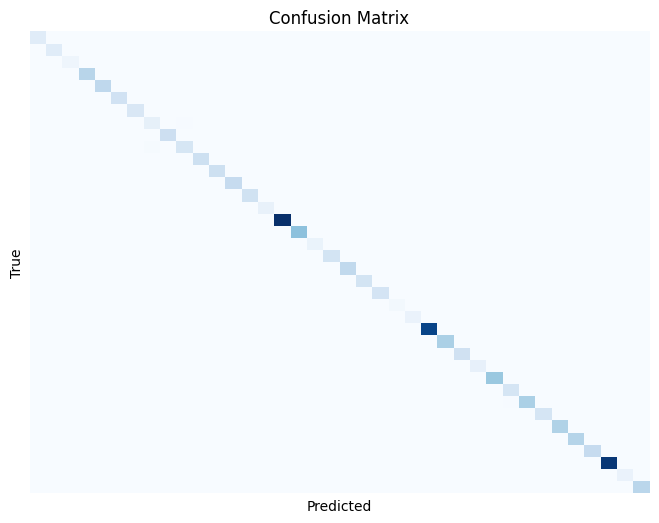

Best Model Results: PlantVillage38-2Path5-LAB-m4-0.25
340/340 [==============================] - 76s 222ms/step


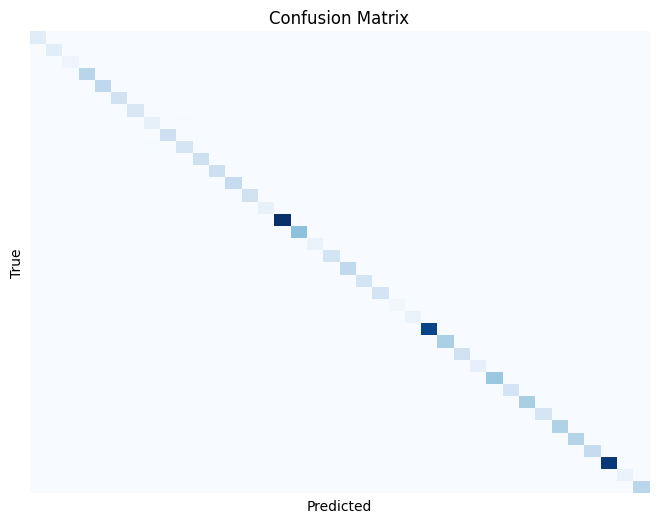

Best Model Results: PlantVillage38-2Path5-LAB-m4-0.5
340/340 [==============================] - 71s 208ms/step


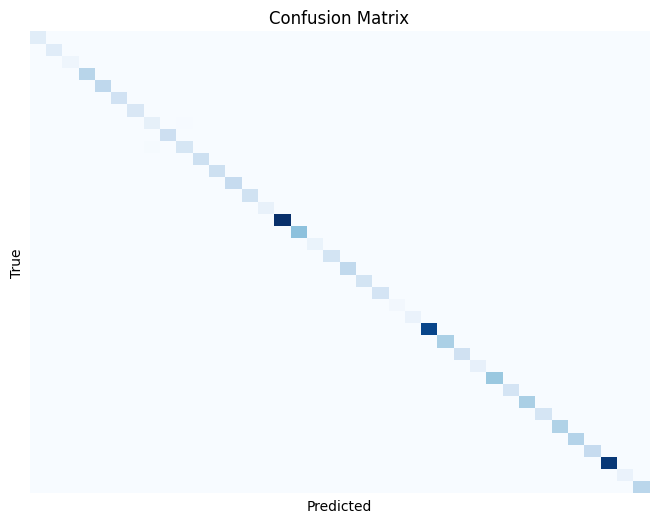

Best Model Results: PlantVillage38-2Path5-LAB-m4-0.75
340/340 [==============================] - 76s 222ms/step


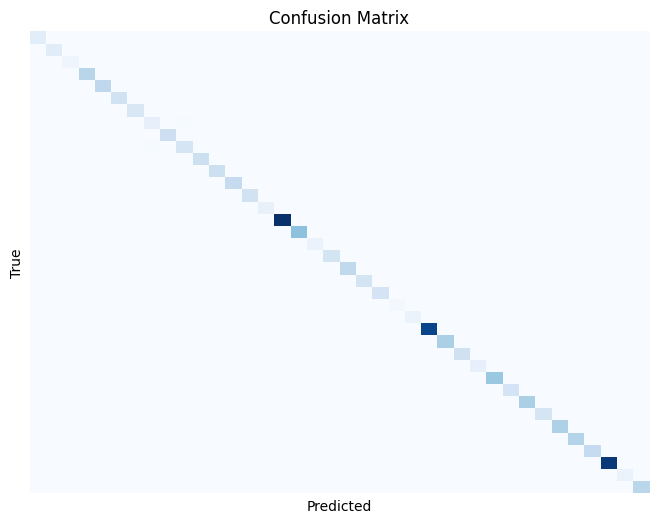

Best Model Results: PlantVillage38-2Path5-LAB-m4-1.0
219/340 [==================>...........] - ETA: 29s

In [ ]:
for l_ratio in [0.0,0.25,0.50,0.75,1.0]:
    
    basefilename = basename + str(l_ratio)
     
    best_result_file_name = basefilename+'-best_result.hdf5'          

    print('Best Model Results: '+basefilename)          
    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )

    # Make predictions
    y_pred_prob = model.predict(test_x)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Create the confusion matrix
    cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
                xticklabels='', yticklabels='')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    figfilename = basefilename+'-CF.png'
    plt.savefig(figfilename, bbox_inches='tight')

    plt.show()

In [ ]:
!ls